<div style='background-image: url("../../share/images/header.svg") ; padding: 0px ; background-size: cover ; border-radius: 5px ; height: 250px'>
    <div style="float: right ; margin: 50px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.7) ; width: 50% ; height: 150px">
        <div style="position: relative ; top: 50% ; transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , 0.8) ; line-height: 100%">Computational Seismology</div>
            <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.5)">Finite Element Method - Static Elasticity</div>
        </div>
    </div>
</div>

<p style="width:20%;float:right;padding-left:50px">
<img src=../../share/images/book.jpg>
<span style="font-size:smaller">
</span>
</p>


---

This notebook is part of the supplementary material 
to [Computational Seismology: A Practical Introduction](https://global.oup.com/academic/product/computational-seismology-9780198717416?cc=de&lang=en&#), 
Oxford University Press, 2016.


##### Authors:
* David Vargas ([@dvargas](https://github.com/davofis))
* Heiner Igel ([@heinerigel](https://github.com/heinerigel))

## Basic Equations

Static elasticity can be considered a particular case derived from the elastic wave equation when the displacement does not depend on time, i.e $\partial_t^2 u(x,t) = 0$. Under this assumption and departing from the 1D elastic wave equation, the differential equation turns into the Poisson equation

\begin{equation}
-\mu \partial_x^2 u = f,
\end{equation}

where $\mu$ is the shear modulus for a homogeneous media, $u$ is the displacement field, and $f$ is the external force. The solution for this problems is found after bringing this equation into its weak form, applying the free boundary condition, and using the Galerkin principle with a suitable basis. Then, the displacement defined in a discrete set of points $x_i$ is given as the solution of a system of N equations, with 

\begin{equation}
\mathbf{u} = (\mathbf{K}^{T})^{-1} \mathbf{f}
\end{equation}

where $\mathbf{K}$ is the stiffness matrix. For an elastic physical system with constant shear modulus $\mu$ and uniform element size $h$, it is given as

\begin{equation}
K_{ij} = \frac{\mu}{h}
 \begin{pmatrix}
   1 & -1 &    &    & \\
  -1 &  2 & -1 &    & \\
     &    & \ddots  &  &  \\
     &    & -1 &  2 & -1   \\
     &    &    & -1 &  1
 \end{pmatrix}
\end{equation}

The purpose of this notebook is to illustrate how the problem of static elasticity is solved with the finite- element method. We also compare the solution using finite - differences, the so-called relaxation method given by (derivation in the book):

\begin{equation}
u_{i}^{k+1} = \dfrac{u_{i}^{k+1} + u_{i}^{k+1}}{2} + \dfrac{h^2}{2 \mu}f_i
\end{equation}

In [1]:
# Import all necessary libraries, this is a configuration step for the exercise.
# Please run it before the simulation code!
import numpy as np
import matplotlib.pyplot as plt

# Show the plots in the Notebook.
plt.switch_backend("nbagg")

### Finite - Element solution

<IPython.core.display.Javascript object>


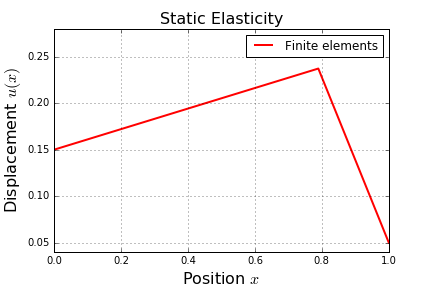

In [2]:
# ---------------------------------------------------------------
# Initialization of setup
# ---------------------------------------------------------------
nx = 20              # Number of boundary points
u  = np.zeros(nx)    # Solution vector 
f  = np.zeros(nx)    # Source vector 
mu = 1               # Constant shear modulus 

# Element boundary points
x = np.linspace(0, 1, nx)  # x in [0,1]
h = x[2] - x[1]            # Constant element size

# ---------------------------------------------------------------
# Assemble stiffness matrix K_ij (Eq 6.30)
# ---------------------------------------------------------------
K = np.zeros((nx, nx))
for i in range(1, nx-1):
    for j in range(1, nx-1):
        if i == j:
            K[i, j] = 2*mu/h
        elif i == j + 1:
            K[i, j] = -mu/h
        elif i + 1 == j:
            K[i, j] = -mu/h
        else:
            K[i, j] = 0

# ---------------------------------------------------------------
# Souce term is a spike at i = 3*nx/4
f[int(3*nx/4)] = 1

# Boundary condition at x = 0
u[0] = 0.15 ; f[1] = u[0]/h

# Boundary condition at x = 1
u[nx-1] = 0.05 ; f[nx-2] = u[nx-1]/h

# ---------------------------------------------------------------
# Finite element solution. (Eq 6.19)
# ---------------------------------------------------------------
u[1:nx-1] = np.linalg.inv(K[1:nx-1, 1:nx-1]) @ np.transpose(f[1:nx-1]) 

# ---------------------------------------------------------------
# Plotting section
# ---------------------------------------------------------------
xfe = u 
plt.plot(x, xfe, color='r', lw=2, label='Finite elements')
plt.title('Static Elasticity', size=16)
plt.ylabel('Displacement $u(x)$', size=16)
plt.xlabel('Position $x$', size=16)
plt.axis([0, 1, 0.04, .28])
plt.legend()
plt.grid(True)
plt.show()

### Finite - Difference solution

<IPython.core.display.Javascript object>


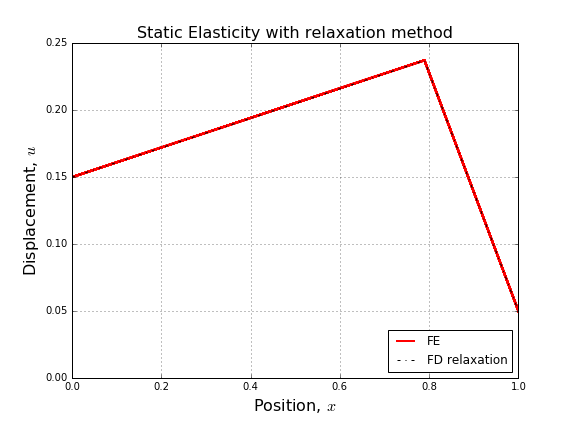

In [3]:
# Poisson's equation with relaxation method
# ---------------------------------------------------------------
nt = 500     # Number of time steps
iplot = 20   # Snapshot frequency

# non-zero boundary conditions
u  = np.zeros(nx)   # set u to zero
du = np.zeros(nx)   # du/dx
f  = np.zeros(nx)   # forcing

f[int(3*nx/4)] = 1./h

xfd = np.arange(0, nx)*h

# ---------------------------------------------------------------
# Initialize animated plot
# ---------------------------------------------------------------
plt.figure(figsize=(8,6))

line1 = plt.plot(x, xfe, color='r', lw=2, label='FE') 
line2 = plt.plot(xfd, u, color='k', ls='-.', label='FD relaxation')
plt.title('Static Elasticity with relaxation method', size=16)
plt.ylabel('Displacement, $u$', size=16)
plt.xlabel('Position, $x$', size=16)
plt.legend(loc=4)
plt.grid(True)

plt.ion()   # set interective mode
plt.show()
# ---------------------------------------------------------------
for it in range(nt):
    # Calculate the average of u (omit boundaries)
    for i in range(1, nx-1):
        du[i] =u [i+1] + u[i-1]
    u = 0.5*( f*h**2/mu + du )
    u[0] = 0.15    # Boundary condition at x=0
    u[nx-1] = 0.05 # Boundary condition at x=1
    fd = u
    
    # --------------------------------------   
    # Animation plot. Display both solutions
    if not it % iplot:
        for l in line2:
            l.remove()
            del l        
        line1 = plt.plot(x, xfe, color='r', lw=2)
        line2 = plt.plot(xfd, fd, color='k', ls='-.')
        plt.gcf().canvas.draw()    